# 2022-MM-DD_001__NAME

## H2 heading

### H3 heading

You can put description, notes, anything.
The idea is that one runs the first cell to initiate, the second cell to set modulation waveforms, the third cell to acquire data.

This supports Markdown: **bold**, _underscored_, [links](https://strath.ac.uk) as well as <span style="color: #1fa774">HTML</span> and even external images.

<img src="https://www.strath.ac.uk/media/1newwebsite/documents/brand/strath_main.jpg" alt="Strathy logo" width="100" height="100"> 

- Running single cell: Ctrl+Enter
- Running single cell and move to next one: Shift+Enter

## Measurement datafile structure

The measurements are saved in datafiles designed to store all data AND metadata for the measurement.
The goal is to have the datafile completely self-sustained, minimizing the need for referencing the corresponding lab-book entry or writing down parameters and filenames by hand.
The datafile is stored as a LZMA-compressed, serialized (pickled) dictionary object (dict) with following hierarchy:

- `fname` _(stores the reference filename defined during acquisition, in case the file would get renamed)_
- `date` _(full date of acquistion, including HH:MM:SS)_
- `repeats` _(how many readouts are taken in the measurement)_
- `modulation` _(stores everything related to AWG modulation)_
    - _all variables in the scope that include `ch1_` and/or `ch2_` are saved alongside the measurement_
    - `wf1/2_xpar`
    - `wf1/2_y`
- `readout_osc_count` _(number of recorded OSC traces)_   
- `readout_osc_1` _(oscilloscope readout traces, numbered as simple integers)_
    - `0`, `1`, `2`, `3`, ...
        - `xpar `
        - `y`
    - `mean` _(simple arithmetic mean for all acquired measurements, useful for quickly checking readouts from a datafile)_
        - `xpar`
        - `y`

NOTE: `xpar` is a three-value tuple which can be directly fed to `np.linspace(*xpar)` to create a correspodning time-values vector for any recorded data.

Contents of any data-dictionary can be directly viewer with `lab.Visualise_Data_Dict(dict)`.

**This notebook is primarily intended for data acquisition (and viewing the recordings after acquisition). Post-processing can be done in this notebook, but would be probably better done in a separate notebook _(all metadata, including AWG modulation, is included with every measurement and can be queried from the datafile)._**

# Scripts & data

In [1]:
isHot = True  # This variable decides on the global state of the notebook. isHot = instruments are connected and controlled, data is acquired and saved.
isSaving = isHot and True
datadir = 'data'
figsdir = 'figs'

# Native libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
from time import sleep
from datetime import datetime
from time import sleep
from tqdm import tqdm
import lzma
import warnings
import os
datadir_full = os.path.join(os.getcwd(),datadir)
import sys
sys.path.insert(0,'C:/git/StrathLab/libs') #Lab PC
sys.path.insert(0,'D:/Repositories/StrathLab/libs') #XMG
from IPython.display import Markdown #for text coloring

# Ensure folders for data and figs exist
if not os.path.isdir(datadir_full):
    os.mkdir(datadir_full)
if not os.path.isdir(os.path.join(os.getcwd(),figsdir)):
    os.mkdir(os.path.join(os.getcwd(),figsdir))

# Instrument libraries
try:
    from RsInstrument import BinFloatFormat
    import RsInstrument as rs
    import pyvisa as visa
    import pyarbtools
    display (Markdown('<span style="color: #1fa774">All instrument control libraries found and loaded.</span>'))
except:
    display (Markdown('<span style="color: #e17701;font-weight:bold">At least one of the instrument library failed to load. Remote control of lab equipment is not operational.</span>'))

# Custom libraries
import StrathLabToolkit as lab

# Initiate remote control for lab instruments
awg = None
rth = None
sm = None

if isHot:
    try:
        awg = pyarbtools.instruments.M8190A('130.159.91.79', port=5025, timeout=30, reset=False)
    except:
        try:
            awg = pyarbtools.instruments.M8190A('127.0.0.1', port=5025, timeout=30, reset=False)
        except:
            warnings.warn('AWG not connected.',RuntimeWarning)
            awg = lab.Mock()
    
    try:
        rth = lab.Initialise_OSC()
    except:
        warnings.warn('Oscilloscope not connected.',RuntimeWarning)
        rth = lab.Mock()
        
    try:
        sm = lab.Initialise_Keithley()
        sm.measure_current(current=0.02, auto_range=True)
        sm.apply_voltage(voltage_range=2, compliance_current=0.02)    
    except:
        warnings.warn('Keithley not connected.',RuntimeWarning)
        sm = lab.Mock()
        
        
else:
    awg = lab.Mock()
    rth = lab.Mock()
    sm = lab.Mock()
#%%

<span style="color: #1fa774">All instrument control libraries found and loaded.</span>

Connected to oscilloscope.
Device IDN: Rohde&Schwarz,RTP,1320.5007k08/100963,4.80.1.0
Device Options: K37,B1,B4,B10,B102,B0816



C:\Users\Antonio\Miniconda3\envs\py37_main\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: Keithley not connected.


## AWG Waveforms

In [2]:
samplerate = 1e9 #between 125e6 and 12e9
using_AWG_channels = None #(1,2) # Denominate used channels: (1,),(2,),(1,2) or 'None' if no modulation
wf_rounding_factor = 1000 # Rounds waveform length to (ideally) avoid high repetitions during AWG synthesis

#### IMPORTANT!!!!: Sets voltage for AWG outputs
ch1_type = 'dac' # 'dac' (direct) or 'dc' (amplified)
ch1_voltage = 0.2  # in volts

ch2_type = 'dac' # 'dac' (direct) or 'dc' (amplified)
ch2_voltage = 0.1

# Note: variables that contain 'ch1_' or 'ch2_' are auto-saved with each measurement
# Therefore, if you want any mod parameters to be saved, make sure their name includes channel reference

################################
if using_AWG_channels != None:
    display (Markdown('<span style="color: #1fa774">Used AWG channels: </span> <span style="color:#1fa774; font-weight:bold">'+str(using_AWG_channels)+'</span>.'))
    # CHANNEL 1
    if 1 in using_AWG_channels:
        ##### CHANGE WF FROM HERE
        ch1_pulse_length_sa = 1
        ch1_trigseparation = 250e-9
        ch1_wf1amp = 1
        ch1_pulse_count = 10
        ch1_separator = 1000e-9
        ch1_offset_A = 0

        wf1_y = np.zeros(100+int(ch1_offset_A*samplerate))

        for ii in range(ch1_pulse_count):
            sep = ch1_trigseparation-(ch1_pulse_length_sa/samplerate)
            wf1_y = np.concatenate((wf1_y,
                                  np.ones(int(ch1_pulse_length_sa))*ch1_wf1amp,
                                  np.zeros(int(sep*samplerate))))

        wf1_y = np.concatenate((wf1_y,np.zeros(int(ch1_separator*samplerate)))) 

        ##### CHANGE WF TO HERE
        wf1len = wf1_y.shape[0]
        print(f'Waveform WF1 length (samples): {wf1_y.shape[0]}')

    else:
        wf1_y = None
    ################################
    # CHANNEL 2
    if 2 in using_AWG_channels:
        ch2_step_len = 1/10e3
        ch2_levels = (0.25,0.5,0.75,1)
        ch2_wf2amp = 1

        offset_B = 40e-9
        zerolvl = 0

        wf2_y = np.ones(100+int(offset_B*samplerate))*zerolvl
        for level in ch2_levels:
            wf2_y = np.concatenate((wf2_y,
                                  np.ones(int(samplerate*ch2_step_len))*ch2_wf2amp*level#,
                                  #np.ones(int(samplerate*step_len))*0
                                  ))
        #### Change to here    
        wf2len = wf2_y.shape[0]    
        print(f'Waveform WF2 length (samples): {wf2_y.shape[0]}')
    else:
        wf2_y = None
    #wf2 = np.concatenate((wf2,np.ones(int(10*separator*samplerate))*zerolvl))    
    #wf2 = wf2/np.max(wf2)

    ###############################
    # Sends created waveform(s) to the instruments
    wf1_xpar, wf2_xpar, fig = lab.Send_WFs_to_AWG(wf1=wf1_y,
                                            out1=ch1_type,
                                            ch1_V=ch1_voltage, 
                                            wf2=wf2_y, 
                                            out2=ch2_type, 
                                            ch2_V=ch2_voltage, 
                                            isHot=isHot, 
                                            awg=awg, 
                                            sr=samplerate, 
                                            channels=using_AWG_channels, 
                                            rounding_fact=wf_rounding_factor)
else:
    display (Markdown('<span style="color: #1fa774">No waveforms sent to AWG (using_AWG_channels == None).</span>'))

<span style="color: #1fa774">No waveforms sent to AWG (using_AWG_channels == None).</span>

### Acquisition

C:\Users\Antonio\Miniconda3\envs\py37_main\lib\site-packages\ipykernel_launcher.py:37: UserWarning: File exists already! Press Enter to continue...


Proceeding with acquisiton...


<span style="color: #014d4e;font-weight:bold">Recording data into: 001_MyDataFile_MeasuringXYZ.</span>

Single channel acq. set on OSC.
Modulation is off. No mod parameters saved.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]


Measurement saved, time: 2022/06/01, 17:37:11
Filesize: 4.6KiB


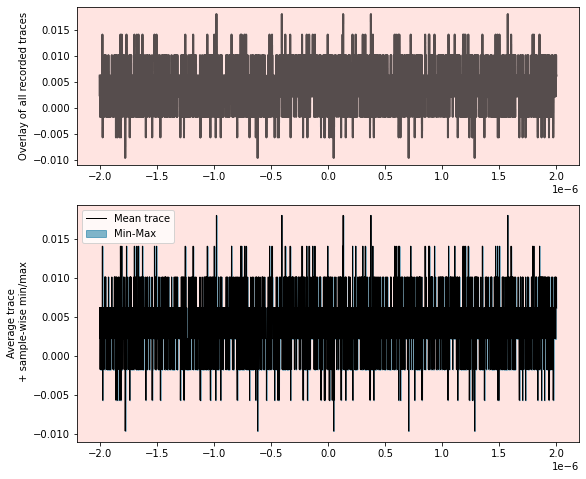

In [7]:
saved_obj = {}
#### THIS IS WHAT YOU SHOULD CHANGE ###############
fname = '001_MyDataFile_MeasuringXYZ'
acq_channels = (1,)  # (1,2,3,4) to select oscilloscope channel(s). Must be tuple: f.e. (1,) for single chan
repeats = 10 # How many acquisitions in sequence should be taken

saved_obj['notes'] = '''
You can save any note you want.
It can be multiple lines.
'''

#### THESE ARE SAVED PARAMETERS (USING THESE IS OPTIONAL, but likely helpful)###########
saved_obj['params'] = {}
#saved_obj['params']['I_{vcsel}'] = 2.200e-3
#saved_obj['params']['I_{EDFA}'] = 123e-3
#saved_obj['params']['V_{MZM}'] = 7.67
#saved_obj['params']['V_{SM_mas}'] = 0.830


##### HERE THE ACTUAL MEASURING STARTS, NO NEED TO CHANGE CODE BELOW ##########            
if isHot == True:
    
    #### Filename synthesis
    now = datetime.now()
    saved_obj['date'] = now.strftime("%Y/%m/%d, %H:%M:%S")
    
    full_fname = now.strftime("%Y-%m-%d")+'__'+fname+'.pkl.lz'
    full_filepath = os.path.join(datadir_full,full_fname)
    
    saved_obj['fname'] = fname
    saved_obj['repeats'] = repeats   
    channelcount = len(acq_channels)
    saved_obj['readout_osc_count'] = channelcount
    
    #### Overwrite check
    if os.path.isfile(full_filepath):
        warnings.warn("File exists already! Press Enter to continue...")
        entered = input()
        if entered != '':
            sys.exit()  
        print('Proceeding with acquisiton...')
    
    display (Markdown(f'<span style="color: #014d4e;font-weight:bold">Recording data into: {fname}.</span>'))
    
    #### Input channels check:
    if not set(acq_channels).issubset((1,2,3,4)):
        warnings.warn("At least one of the specified OSC channel numbers is out of allowed range.")
        sys.exit() 
    else:
        lab.Set_OSC_Channels(rth, acq_channels, verbose = True)
    
    #### Saving all modulation parameters via keywords search
    if using_AWG_channels != None:
        saved_obj['modulation'] = {}
        saved_obj['modulation']['samplerate'] = samplerate
        for jjj in using_AWG_channels:
            #wholex = eval(f'wf{jjj}_x')
            saved_obj['modulation'][f'wf{jjj}_xpar'] = eval(f'wf{jjj}_xpar')
            saved_obj['modulation'][f'wf{jjj}_y'] = eval(f'wf{jjj}_y')

            print(f'Mod parameters (CH{jjj}) saved:\n[',end='')
            saved_wf_par_counter = 0
            for var in dir():
                if f'ch{jjj}_' in var:
                    saved_obj['modulation'][var] = eval(var)
                    saved_wf_par_counter = saved_wf_par_counter+1
                    print(var,end=', ')
            print(']')
    else:
        print(f'Modulation is off. No mod parameters saved.')
        saved_obj['modulation'] = None
     
    #### Saving Keithley voltage if available
    try:
        sm_I,sm_V = lab.Keithley_getReadout(sm)
        saved_obj['params']['V_sm'] = sm_V
        print(f'Keithley SM voltage: {sm_V}')
    except:
        pass
    
    #### Create plots: overlay of all measurements, mean+min/max
    if channelcount == 1:
        figR,axR = plt.subplots(2,1,figsize=(9,8),gridspec_kw={'height_ratios':(1,1.5)})
    else:
        figR,axR = plt.subplots(2,channelcount,figsize=(7+2*channelcount,8),gridspec_kw={'height_ratios':(1,1.5)})
 
    #### Get readout shape to create according arrays
    ytotal = {}
    ymin = {}
    ymax = {}

    t, ys = lab.Acq_OSC_Traces(rth, acq_channels)
    for ch_no, ch in enumerate(acq_channels):        
        y = np.asarray(ys[str(ch)])

        ytotal[str(ch)] = np.zeros(y.shape)
        ymin[str(ch)] = y.copy()
        ymax[str(ch)] = y.copy() 
        saved_obj[f'readout_osc_{ch_no}'] = {}
    
    #### Measure
    pbar = tqdm(total=repeats*len(acq_channels))
    #pbar.set_description()
    for jjj in range(repeats):          
        xpar, ys = lab.Acq_OSC_Traces(rth, acq_channels)
        for ch_no, ch in enumerate(acq_channels):  
            y = np.asarray(y)
            saved_obj[f'readout_osc_{ch_no}'][f'{jjj}'] = {}
            saved_obj[f'readout_osc_{ch_no}'][f'{jjj}']['xpar'] = xpar
            saved_obj[f'readout_osc_{ch_no}'][f'{jjj}']['y'] = ys[str(ch)]
            
            if channelcount == 1:
                axR[0].plot(np.linspace(*xpar),ys[str(ch)],color='xkcd:black',lw=2,alpha=1/repeats)
            else:
                axR[0,ch_no].plot(np.linspace(*xpar),ys[str(ch)],color='xkcd:black',lw=2,alpha=1/repeats)
     
            ytotal[str(ch)] = ytotal[str(ch)]+ys[str(ch)]
            ymin[str(ch)] = np.minimum(ymin[str(ch)],ys[str(ch)])
            ymax[str(ch)] = np.maximum(ymax[str(ch)],ys[str(ch)])
            pbar.update(1)
    pbar.close()       

    #### Render mean, maximum, minimum readouts
    
    if len(acq_channels) == 1:
        ytotal[str(ch)] = ytotal[str(ch)]/repeats     
        #axR[1].plot(t,,color='xkcd:evergreen',lw=0.5,alpha=0.5,label='Min')
        axR[1].fill_between(np.linspace(*t),ymin[str(ch)],ymax[str(ch)],color='xkcd:ocean blue',alpha=0.5,label='Min-Max')
        axR[1].plot(np.linspace(*t),ytotal[str(ch)],color='xkcd:black',lw=1,label='Mean trace')
        axR[1].legend()
        axR[0].set_facecolor((1.0, 0.47, 0.42,0.2))
        axR[1].set_facecolor((1.0, 0.47, 0.42,0.2))
        axR[0].set_ylabel('Overlay of all recorded traces')
        axR[1].set_ylabel('Average trace\n + sample-wise min/max')

        #### Dump mean trace into the file for convenience
        saved_obj[f'readout_osc_{ch_no}']['mean'] = {}
        saved_obj[f'readout_osc_{ch_no}']['mean']['xpar'] = xpar
        saved_obj[f'readout_osc_{ch_no}']['mean']['y'] = ytotal
    else:    
        for ch_no, ch in enumerate(acq_channels):       
            ytotal[str(ch)] = ytotal[str(ch)]/repeats     
            #axR[1].plot(t,,color='xkcd:evergreen',lw=0.5,alpha=0.5,label='Min')
            axR[1,ch_no].fill_between(np.linspace(*t),ymin[str(ch)],ymax[str(ch)],color='xkcd:ocean blue',alpha=0.5,label='Min-Max')
            axR[1,ch_no].plot(np.linspace(*t),ytotal[str(ch)],color='xkcd:black',lw=1,label='Mean trace')
            axR[1,ch_no].legend()
            axR[0,ch_no].set_facecolor((1.0, 0.47, 0.42,0.2))
            axR[1,ch_no].set_facecolor((1.0, 0.47, 0.42,0.2))
            axR[0,ch_no].set_ylabel('Overlay of all recorded traces')
            axR[1,ch_no].set_ylabel('Average trace\n + sample-wise min/max')

            #### Dump mean trace into the file for convenience
            saved_obj[f'readout_osc_{ch_no}']['mean'] = {}
            saved_obj[f'readout_osc_{ch_no}']['mean']['xpar'] = xpar
            saved_obj[f'readout_osc_{ch_no}']['mean']['y'] = ytotal
        figR.tight_layout()
    #### Save everything into LZMA-compressed pickled (serialized) file
    if isSaving:
        memsize = sys.getsizeof(saved_obj)
        #print(f'Object size (memory): {memsize} [{lab.filesize_fmt(memsize)}]')
        with lzma.open(full_filepath,"wb",preset=3) as f:
            pickle.dump(saved_obj,f)
            print(f'Measurement saved, time: {saved_obj["date"]}')
        print('Filesize: '+lab.Filesize_Fmt(os.stat(full_filepath).st_size))
else:
    display (Markdown('<span style="color: #e17701;font-weight:bold">The global acquisition switch (isHot) is set to FALSE. No data recorded.</span>'))

## **Data visualization**

In [8]:
## Visualize contents of a recorded measurement datafile
dfile = '2022-06-01__001_MyDataFile_MeasuringXYZ.pkl.lz'
with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
    loaded_obj = pickle.load(f)
    lab.Visualise_Data_Dict(loaded_obj)

KEY                       LEVEL           TYPE      
-------------------------------------------------------------------------------
date                      0               <str>: 2022/06/01, 17:37:11
fname                     0               <str>: 001_MyDataFile_MeasuringXYZ
modulation                0               <NoneType>
notes                     0               <str>: 
You can save any note you want.
It can be multiple lines.

params                    0               <dict>    
readout_osc_0             0               <dict>: 10x | 1.00e+09 Sa/s, 4000 Sa
readout_osc_count         0               <int>: 1  
repeats                   0               <int>: 10 


File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">MyDataFile.</span> Found files: <span style="color:#1fa774; font-weight:bold">1</span>

KeyError: 'readout_osc_1'

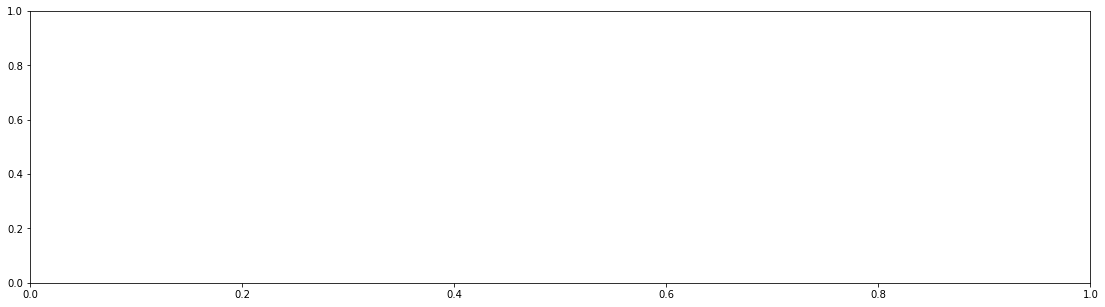

In [9]:
# MULTI-DATA VIEWER
lookup = 'MyDataFile'
osc_trace_no = 1 #integer specifying count of returned OSC channel
x_range = (0.1,0.9)
############################
datafiles = lab.Get_Files_From_Dir(os.path.join(datadir_full))

filecounter = 0
for dfile in datafiles:
    if lookup in dfile:
        filecounter = filecounter+1  
        
if filecounter > 0:
    display (Markdown(f'File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">{lookup}.</span> Found files: <span style="color:#1fa774; font-weight:bold">{filecounter}</span>'))  
    if filecounter == 1:
        figA,axA= plt.subplots(1,1,figsize=(19,5)) 
    else:
        figA,axA= plt.subplots(filecounter,1,figsize=(14,5+(filecounter-1)*3)) 
        
    figcounter = 0
    for dfile in datafiles:
        if lookup in dfile:        
            with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
                loaded_obj = pickle.load(f) 
                repeats = loaded_obj['repeats']
                
                if repeats > 1:
                    prnt_string = '<span style="color: #1fa774">Loaded file:</span> <span style="color:#1fa774; font-weight:bold">'+dfile+'</span>. <br>'+f'- Multitrace (n={repeats}) measurement readout.'
                    
                    ytotal = np.zeros(loaded_obj[f'readout_osc_{osc_trace_no}']['0']['y'].shape[0])
                    
                    for jjj in range(repeats):
                        xpar = loaded_obj[f'readout_osc_{osc_trace_no}'][str(jjj)]['xpar']
                        ytotal = ytotal + loaded_obj[f'readout_osc_{osc_trace_no}'][str(jjj)]['y']    
                    
                    t = np.linspace(*xpar)
                    ytotal = ytotal/repeats
                    
                    try:    
                        wf1 = loaded_obj['modulation']['wf1_y']
                        xax1 = np.linspace(*loaded_obj['modulation']['wf1_xpar'])   
                        prnt_string = prnt_string + '  |  Mod1'
                    except:
                        pass
                    try:
                        wf2 = loaded_obj['modulation']['wf2_y']
                        xax2 = np.linspace(*loaded_obj['modulation']['wf2_xpar'])
                        prnt_string = prnt_string + '  |  Mod2'
                    except:
                        pass
                    
                    
                    display (Markdown(prnt_string+'\n'))
                    
                    if filecounter > 1:                     
                        axA[figcounter].plot(t,ytotal,color='xkcd:dark green',lw=0.75,alpha=1,label=f'Mean trace (from n={repeats})')    
                        axA[figcounter].set_xlim((t[int(t.shape[0]*x_range[0])],t[int(t.shape[0]*x_range[1])]))                           
                        
                        axM = axA[figcounter].twinx()
                        try:
                            axM.plot(xax1[0:wf1.shape[0]],wf1,color='xkcd:indigo',alpha=0.6,lw=0.5,ls='--',label='MOD WF1') 
                        except:
                            pass
                        try:
                            axM.plot(xax2[0:wf2.shape[0]],wf2,color='xkcd:royal purple',alpha=0.6,lw=0.75,ls='-.',label='MOD WF2')
                        except:
                            pass
                        
                        axA[figcounter].legend(loc='upper left')
                        axM.legend(loc='upper right')
                    elif filecounter == 1:
                        axA.plot(t,ytotal,color='xkcd:dark green',lw=0.75,alpha=1,label=f'Mean trace (from n={repeats})')    
                        axA.set_xlim((t[int(t.shape[0]*x_range[0])],t[int(t.shape[0]*x_range[1])]))                           
                        
                        axM = axA.twinx()
                        try:
                            axM.plot(xax1[0:wf1.shape[0]],wf1,color='xkcd:indigo',alpha=0.6,lw=0.5,ls='--',label='MOD WF1') 
                        except:
                            pass
                        try:
                            axM.plot(xax2[0:wf2.shape[0]],wf2,color='xkcd:royal purple',alpha=0.6,lw=0.75,ls='-.',label='MOD WF2') 
                        except:
                            pass
                        
                        axA.legend(loc='upper left')
                        axM.legend(loc='upper right')
                        
                    figcounter = figcounter+1
else:
    display (Markdown(f'File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">{lookup}.</span> Found files: <span style="color:#ff474c; font-weight:bold">{filecounter}</span>.'))

In [ ]:
## Opening a single data file for post-processing
dfile = '2022-05-05__001_MyDataFile_MeasuringXYZ.pkl.lz'
osc_trace_no = 1
with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
    loaded_obj = pickle.load(f)
    
    #### Plotting what you want
    fig, ax = plt.subplots(2,1,figsize = (12,10)) 

    try:
        modx = np.linspace(*np.linspace(*loaded_obj['modulation']['wf1_xpar'])
        mody = np.linspace(loaded_obj['modulation']['wf1_y']
        ax[0].plot(modx,mody,color='red')
        ax[0].set_title('Measurement repetitions' + str(loaded_obj['repeats']))
    
    x = np.linspace(*loaded_obj[f'readout_osc_{osc_trace_no}']['mean']['xpar'])
    y = loaded_obj[f'readout_osc_{osc_trace_no}']['mean']['y']
    
    ax[1].plot(x,y,color='xkcd:crimson')
    ax[1].set_title('Measurement repetitions' + str(loaded_obj['repeats']))
    
    fig.savefig('figs\\test.png')